### Imports

In [1]:
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

### Local imports

In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

### Functions

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    result = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())

    return result

In [4]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [5]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_thresholds_federated(all_thresholds):
    thresholds_sum = []
    n = 0
    for configuration, configuration_thresholds in all_thresholds.items():
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run_thresholds in configuration_thresholds:
            n += 1
            for federation_round, round_threshold in enumerate(run_thresholds):
                if federation_round >= len(thresholds_sum):
                    thresholds_sum.append(0.)  
                thresholds_sum[federation_round] += round_threshold
    thresholds = [s / n for s in thresholds_sum]
                
    return thresholds

In [6]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [7]:
def plot_federated_acc(results_to_plot, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    if multi_epoch:
        ax.set_xlabel('Federation round')
    else:
        ax.set_xlabel('Epoch')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [8]:
def plot_global_thresholds(thresholds, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color = 'purple'
    ax.set_title(title)
    ax.set_ylabel('Threshold', color=color)
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.plot(thresholds, color=color)
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(np.arange(0, 120, step=10))
        ax.plot(np.arange(0,120, step=10), thresholds, color=color)

    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    ax.set_ylim(ymin=0)
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [9]:
def percentage_str(value, bf=False):
    s = '{:.2f}\\%'.format(value * 100)
    if bf:
        s = '\\textbf{' + s + '}'
    return s

In [10]:
def print_rates_latex(results):
    print('Accuracy:\t' + percentage_str(results.acc(), bf=True))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))

In [11]:
def print_rates_latex2(results):
    print('Accuracy:\t' + percentage_str(results.acc()))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))
    print('F1-Score:\t' + percentage_str(results.f1()))

In [12]:
def get_average_threshold_non_federated(thresholds_dict):
    threshold_sum = 0.
    counter = 0
    for configuration, configuration_results in thresholds_dict.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            counter += 1
            threshold_sum += run_result[0]
    return threshold_sum / counter

### Non-federated

In [13]:
path_test = 'test_results/decentralized_classifier/0,0787 5rr/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print('Local result:')
print_rates_latex(local_result)
print()

print('New result:')
print_rates_latex(new_result)

Local result:
Accuracy:	\textbf{99.78\%}
TPR:		99.98\%
TNR:		97.49\%

New result:
Accuracy:	\textbf{98.94\%}
TPR:		99.58\%
TNR:		91.44\%


### Threshold

In [14]:
path_test = 'test_results/decentralized_autoencoder/0,5 5rr mean+std/'

with open(path_test + 'thresholds.json') as json_file:
    thresholds = json.load(json_file)

avg_threshold = get_average_threshold_non_federated(thresholds)
print(avg_threshold)

1072714934.0549066


### Federated

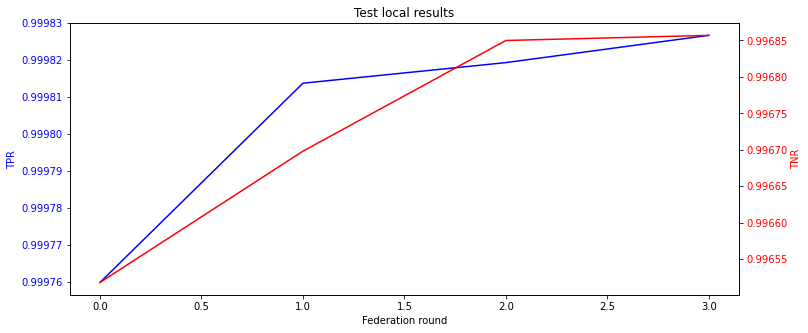

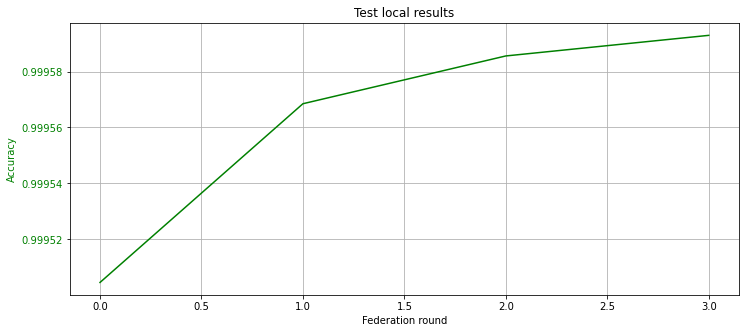

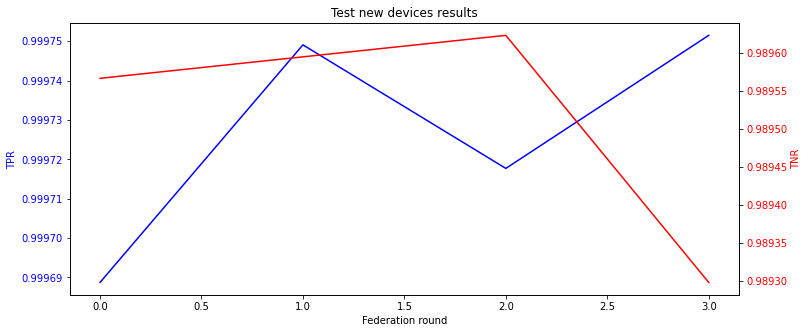

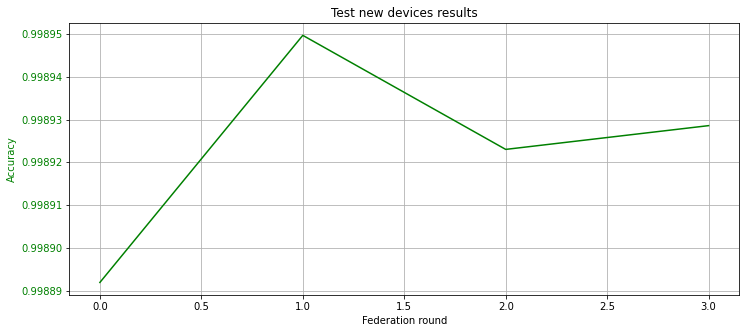

Local result at last round:
Accuracy:	\textbf{99.96\%}
TPR:		99.98\%
TNR:		99.69\%

New result at last round:
Accuracy:	\textbf{99.89\%}
TPR:		99.98\%
TNR:		98.93\%


In [15]:
# TODO: rename the x-axis as epoch in fedsgd and make it start at 1 in both cases

path_test = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,0787 5rr/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results', multi_epoch=True)

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

print('Local result at last round:')
print_rates_latex(local_results_per_round[-1])
print()

print('New result at last round:')
print_rates_latex(new_results_per_round[-1])

In [26]:
def plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color1 = 'red'
    color2 = 'green'
    color3 = 'blue'
    
    ticks = list(np.arange(1, len(res1)+1))   
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(ticks)
    
    ax.grid()
        
    ax.set_ylabel('Accuracy')
    ax.plot(ticks,[result.acc() for result in res1], color=color1, label='7.87% benign')
    ax.plot(ticks,[result.acc() for result in res2], color=color2, label='50% benign')
    ax.plot(ticks,[result.acc() for result in res3], color=color3, label='95% benign')
    
    ax.hlines(0.9996, xmin=ticks[0], xmax=ticks[-1], color=color1, linestyles='dotted', label='7.87% benign (centralized)')
    ax.hlines(0.9991, xmin=ticks[0], xmax=ticks[-1], color=color2, linestyles='dotted', label='50% benign (centralized)')
    ax.hlines(0.9993, xmin=ticks[0], xmax=ticks[-1], color=color3, linestyles='dotted', label='95% benign (centralized)')

    
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    
    
    ax.set_ylim(0.992, 0.9997)
    ax.set_xlim(ticks[0], ticks[-1])
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

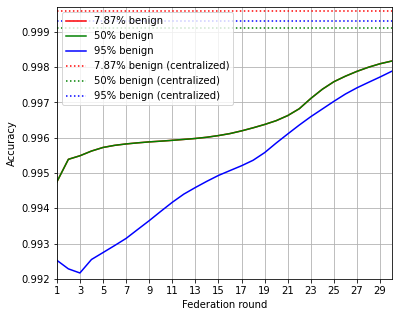

In [29]:
#path_1 = 'test_results/decentralized_classifier_fedavg/0,0787 5rr/'
path_2 = 'test_results/decentralized_classifier_fedavg/0,5 5rr/'
path_3 = 'test_results/decentralized_classifier_fedavg/0,95 5rr/'
path_1=path_2

# path_1 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,0787 5rr/'
# path_2 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,5 5rr/'
# path_3 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr/'


with open(path_1 + 'local_results.json') as json_file:
    all_results_1 = json.load(json_file)

with open(path_2 + 'local_results.json') as json_file:
    all_results_2 = json.load(json_file)
    
with open(path_3 + 'local_results.json') as json_file:
    all_results_3 = json.load(json_file)
    
res1 = get_results_per_round(all_results_1)
res2 = get_results_per_round(all_results_2)
res3 = get_results_per_round(all_results_3)

plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=True)

In [18]:
def plot_global_thresholds_2(thresholds_1, thresholds_2, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color_1 = 'purple'
    color_2 = 'green'
    ax.set_title(title)
    ax.set_ylabel('Threshold')
    ax.set_ylim(0, 0.0105)
    
    
    
    if multi_epoch:
        ticks = list(np.arange(1, len(thresholds_1)+1))
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ticks = list(np.arange(1, len(thresholds_1)*10+1, step=10))
        ax.set_xticks(ticks)
                
    
        
    ax.plot(ticks, thresholds_1, color=color_1, label='mean + std')
    ax.plot(ticks, thresholds_2, color=color_2, label='0.95 quantile')
    
    ax.hlines(0.001566670167570313, xmin=ticks[0], xmax=ticks[-1], color=color_1, linestyles='dotted', label='mean + std (centralized)')
    ax.hlines(0.0012821135499204198, xmin=ticks[0], xmax=ticks[-1], color=color_2, linestyles='dotted', label='0.95 quantile (centralized)')

    ax.set_xlim(ticks[0], ticks[-1])
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

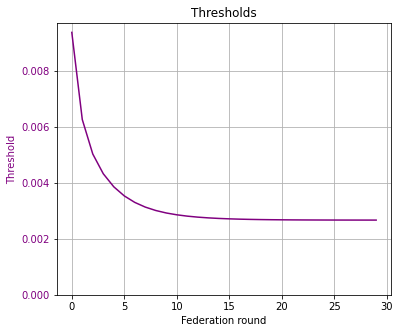

In [19]:
path_1 = 'test_results/decentralized_autoencoder_fedavg/0,5 5rr mean+std/'
with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)


global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
plot_global_thresholds(global_thresholds_1, 'Thresholds', multi_epoch=True, save=True)

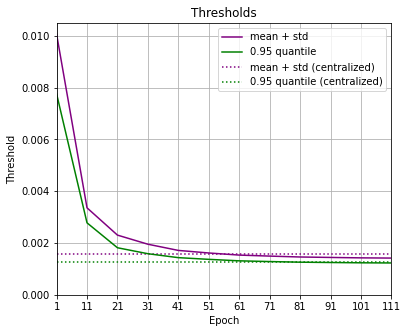

In [20]:
path_1 = 'test_results/decentralized_autoencoder_fedsgd/0,5 5rr mean+std/'
path_2 = 'test_results/decentralized_autoencoder_fedsgd/0,5 5rr 0,95quantile/'

with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)

with open(path_2 + 'thresholds.json') as json_file:
    all_thresholds_2 = json.load(json_file)
    
global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
global_thresholds_2 = get_thresholds_federated(all_thresholds_2)
plot_global_thresholds_2(global_thresholds_1, global_thresholds_2, 'Thresholds', multi_epoch=False, save=True)

These plots are interesting but could be improved with confidence intervals.